In [38]:
words = open('names.txt', 'r').read().splitlines()

print('total number of names: ', len(words), 
      '. Min name length is: ', min(len(w) for w in words), 
      '. Max name length is: ', max(len(w) for w in words))

total number of names:  32033 . Min name length is:  2 . Max name length is:  15


* Bigram - 对于给定的一段文本，每两个相邻单词 就是一个Bigram。例如： I am good. 其中 I am 和 am good是两个Bigram。
* 通常，我们会人为给一段文本的开始和末尾分别添加一个 起始和结束的 特殊字符来给文本的第一个和最后一个词配对组成Bigram。例如：`<S>I am good.<E>`中就多出了 `<S>I` 和 `good<E>`这两个Bigram

In [39]:
b = {}
for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1

# b 存放了 每个bigram (key)所出现的频次 (value)。下面我们将 b 按照每个bigram的频次进行降序排列
sorted(b.items(), key = lambda kv: -kv[1])
print('done')

done


使用PyTorch

In [40]:
import torch

a = torch.zeros((3, 5), dtype=torch.int32)
a.dtype, a

(torch.int32,
 tensor([[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]], dtype=torch.int32))

如果我想要通过 行列 index对 tensor中的某个元素的值进行运算赋值，可以如下进行：

现在我们想要创建一个包含26个字母和`<S>`, `<E>`的 tensor 方阵 （28 x 28）

In [41]:
N = torch.zeros(28, 28, dtype=torch.int32)    # 行表示 前一个字母；列表示 后一个字母。例如: hello --> <S>h ; he; el; ll; lo; o<E>

chars = sorted(list(set(''.join(words))))     # 创建了一个 从a到z 含有26个字母的 list

stoi = {s: i for i, s in enumerate(chars)}    # {'a': 0, 'b': 1, ..., 'z': 25}  {str: int}
stoi['<S>'] = 26; stoi['<E>'] = 27


# 遍历所有的单词，然后统计 组成每个单词的字母中 
for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]; ix2 = stoi[ch2]    # ix1, ix2 分别表示 前一个字母和后一个字母 在stoi中的 index
    N[ix1, ix2] += 1                    # 统计 每对字母 的频率。例如 hihi --> <S>h = 1; hi = 2; ih = 1; i<E> = 1

print(len(N))

28


(-0.5, 27.5, 27.5, -0.5)

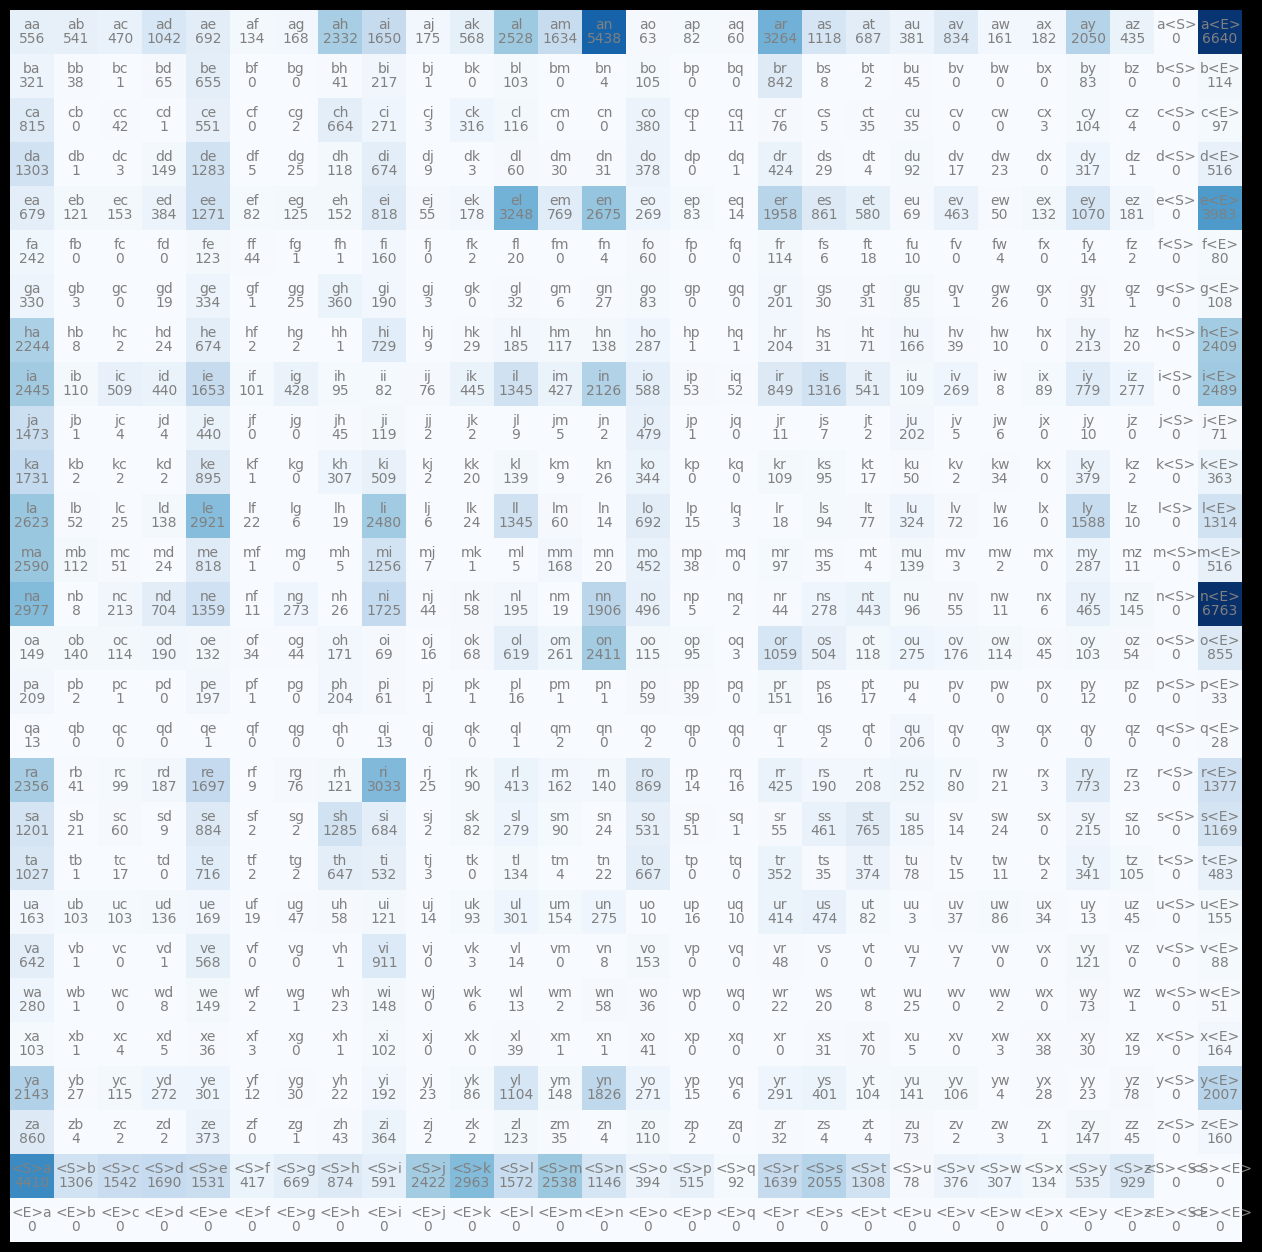

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

itos = {i: s for s, i in stoi.items()}   # string to int

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(28):
  for j in range(28):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')   # N[i, j].item() 通过.item() 方法获取到 第i行j列的元素值 （int）。否则PyTorch只能返回一个tensor类

plt.axis('off')

你会发现上面的矩阵的最后一行和倒数第二列是冗余的，因为`<E>`永远不会作为 第一个字母出现；同理`<S>`永远不会作为最后一个字母出现。所以我们可以将`<S>`和`<E>`合并为 `.`，将上面的矩阵缩减成27 x 27的大小：

27


(-0.5, 26.5, 26.5, -0.5)

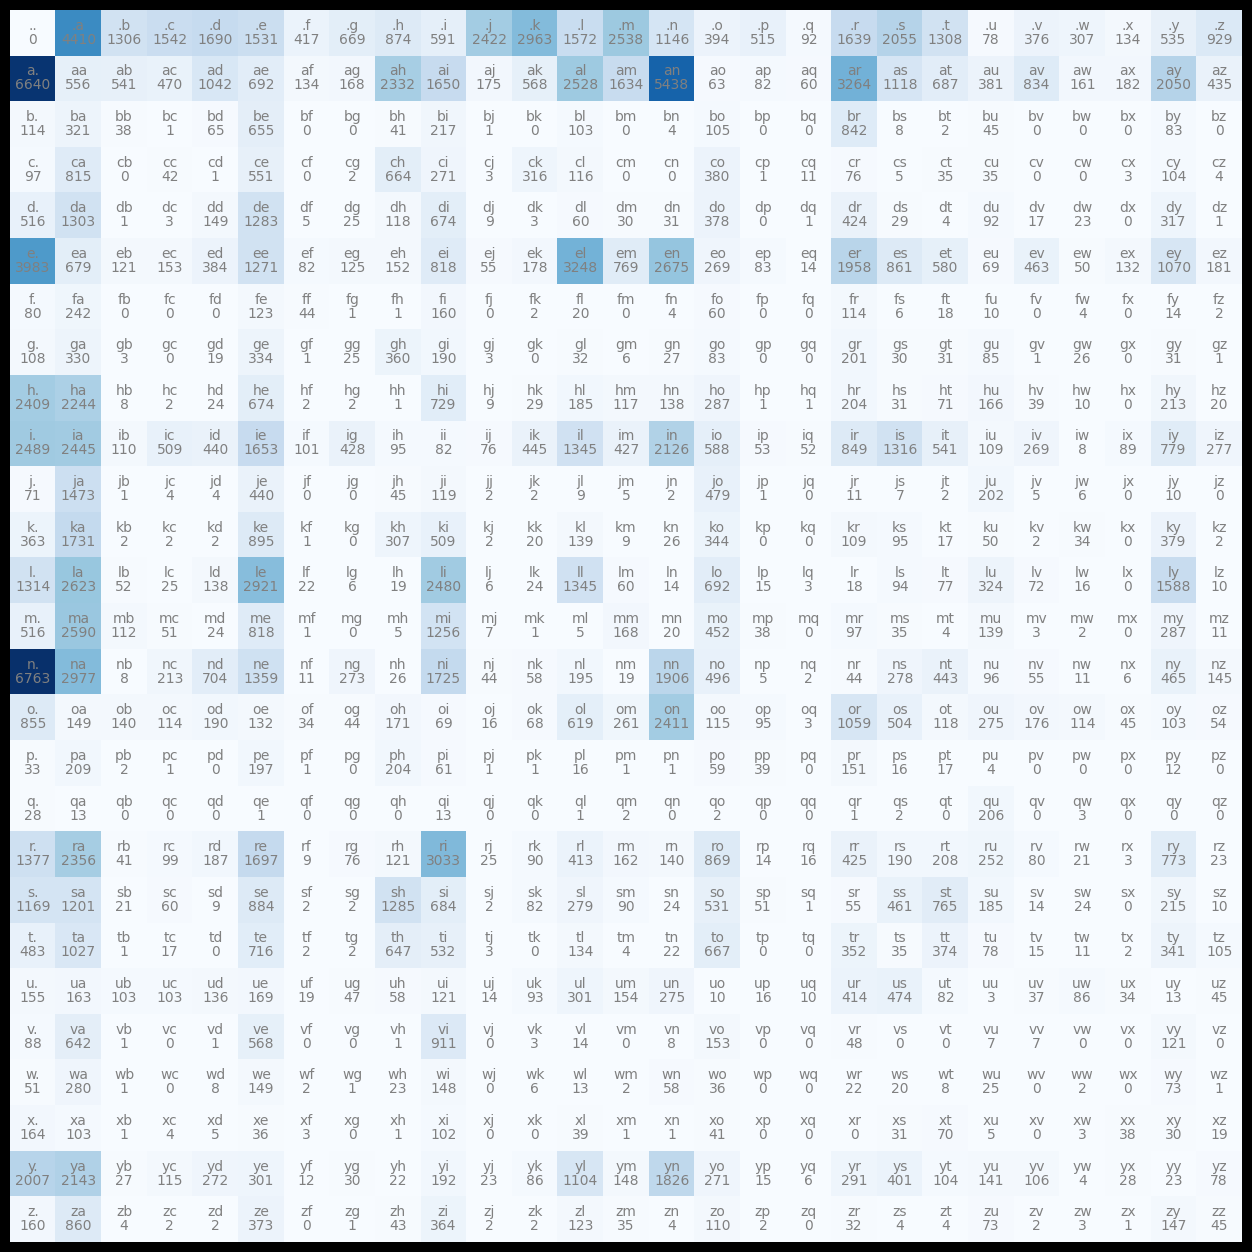

In [43]:
N = torch.zeros(27, 27, dtype=torch.int32)    # 行表示 前一个字母；列表示 后一个字母。例如: hello --> .h ; he; el; ll; lo; o.

chars = sorted(list(set(''.join(words))))     # 创建了一个 从a到z 含有26个字母的 list

stoi = {s: i+1 for i, s in enumerate(chars)}    # {'a': 0, 'b': 1, ..., 'z': 25}  {str: int}
stoi['.'] = 0

itos = {i: s for s, i in stoi.items()}   # string to int

# 遍历所有的单词，然后统计 组成每个单词的字母中 
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]; ix2 = stoi[ch2]    # ix1, ix2 分别表示 前一个字母和后一个字母 在stoi中的 index
    N[ix1, ix2] += 1                    # 统计 每对字母 的频率。例如 hihi --> .h = 1; hi = 2; ih = 1; i. = 1

print(len(N))

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
  for j in range(27):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')


然后，假设我们取上面矩阵`N`的第一行 `N[0]`，然后生成

In [73]:
p = N[0].float()    # convert each element in N[0] to float type
p = p / p.sum()

g = torch.Generator().manual_seed(2147483647)   # 定义 随机数生成器Generator的random seed
p = torch.rand(3, generator=g)                  # 通过PyTorch和Generator生成3个随机数，值域在[0, 1) 之间。这里生成的三个随机数将作为三个概率
p = p / p.sum()                                 # normalization
print(p)

# 使用上面生成的三个概率，分别生成对应个数的 0, 1, 2 （60%， 30%， 10%）
torch.multinomial(p, num_samples=100, replacement=True, generator=g)

tensor([0.6064, 0.3033, 0.0903])


tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

In [80]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
print('randomly generated character is: ', itos[ix])

for i in range(20):
  out = []
  ix = 0
  while True:
    p = N[ix].float()   # 将第一行变成一个行向量 float type
    p = p / p.sum()     # normalize 行向量
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()    # 随机生成一个行向量的索引
    out.append(itos[ix])
    if ix == 0:         # 如果生成了 0，则停止
      break
  print(''.join(out))

randomly generated character is:  d
exze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.
ka.
emimmsade.
enkaviyny.
ftlspihinivenvorhlasu.
dsor.
br.
jol.
pen.
aisan.
ja.


In [84]:
'''
例如 P = N.float(); P.sum(axis=1, keepdim=True)
P 就将会是一个 27 x 1 的列向量
'''
P = N.float()
P.sum(axis=1, keepdim=True).shape   # keepdim=True表示：输出tensor与 输入tensor的大小相同，但除了（行或列为）1的情况。该行输出一个27 x 1的列向量

'''
理解了keepdim=True的意义之后，我们想要normalize P：
P = P / P.sum(1, keepdim=True)
但是我们能不能直接进行 / 运算？
——这需要看一下 Broadcasting Semantics (Rules)。详见：https://pytorch.org/docs/stable/notes/broadcasting.html
简单来说，如果某个PyTorch运算支持 Broadcasting Semantics，就意味着它的tensor参数就会自动扩展为大小相等的参数（无需复制数据）。例如：
例1: x = torch.empty(5, 7, 3); y = torch.empty(5, 7, 3)   # x y是相同size，只要相同size，就是broadcastable的
例2: x = torch.empty((0, )); y = torch.empty(2, 2)        # 这种情况下 x, y就不是 broadcastable的，因为size不同
例3: x = torch.empty(5, 3, 4, 1)
    y = torch.empty(   3, 1, 1)    # 这里，x,y 是 broadcastable的。因为：
      # 1st trailing dimension: both have size 1
      # 2nd trailing dimension: y has size 1
      # 3rd trailing dimension: x size == y size
      # 4th trailing dimension: y dimension doesn't exist
例4: x = torch.empty(5, 2, 4, 1)
    y = torch.empty(   3, 1, 1)     # 这里的x y 不是 broadcastable的。因为size从后往前数的第三个元素 2 != 3

简单来说，掌握下面两个要点：
1. 在 size中，1可以和任何其他值 相等；
2. 两个tensor的size中的值 都是从后往前进行比较的 (trailing dimension)
'''

torch.Size([27, 1])